[View in Colaboratory](https://colab.research.google.com/github/agerk/dataScience/blob/master/probabilistic_programming_from_scratch.ipynb)

In [0]:
import random
import itertools
from matplotlib import pylab as plt

<h2>An A/B testing? </h2>

Choosing two website layout: A and B

In [0]:
# A/B testing for a website
# testing two website layout: A and B
# case 1: 4% of visitors to layout A convert-- buy, sell something, sign up
# case 2: 5% of layout B convert
# Problem: which layout should company used?

# clearly layout B is better, but how what about if the test was ver small?

# looking closer on the stat
n_visitors_a = 100    # num of visitors shown layout A
n_convert_a = 4    # num of visitors converted to A

n_visitors_b = 40    # num of visitors shown layout B
n_convert_b = 2    # numo f visitors converted to B




 - is B still better ? 
 - what if its going to cost a lot to change layout if we get the decsion wrong? 
 - how much more data would we need to feel comfortable in our decsion? 

**to answer the above questions we need to quantify exactly how confident we are about layout B is better, given the dataset**

<h2>Bayesian inference </h2>

a simple algorithm with Bayesian inference for updating our beliefs. This can be done using simple inference algorith called **Approximate Bayesian Computation (ABC)**

- simulate function on a single sample fromprior and compare it against real data
- if it agrees, saple from  the prior can be used as a sample from posterior. if not try again 
- generate enough simulations using a lot of samples from prior and we will have good idea of which values were most likely to produce the obsevations we saw

In [0]:
# function to turn prior distributio to posterior distribution
# prior distribution --> conversion of fraction of layout A and B
# sample from posterior distribution --> guesses of the same parameters made after the experiment
def posterior_sampler(data, prior_sampler, simulate):
  """
  Args: data, prior dist
  Returns: sample from posterior dist by Approximate Bayesian Computation(ABC)
  """
  for p in prior_sampler:
    if simulate(p) == data:    
      yield p   # generator which yields sample from prior

<h3> Using the probabilistc sampler for A/B testing</h3>

- Step 1 simulate

In [0]:
def simulate_conversion(p, n_visitors):
  """
  Args: conversion fraction ,p-- generate random floating point number between 0 and 1 smaller than p
        number of visitors-- sample n_visitor times
        
  Returns: number of visitors who convert
  """
  outcomes = (random.random() < p for i in range(n_visitors))    # iterable booleans, True if success and False otherwise
  return sum(outcomes)    # sum of iterable of booleans is equal to number of True elements

In [96]:
# runf simulate_conversion() for a few examples
simulate_conversion(0.1, 100), simulate_conversion(0.1, 100), simulate_conversion(0.1, 100)

(6, 10, 8)

Step 2: prior sample: a generator that yields a large number of guesses for the conversion of fraction layout. 

In [0]:
def uniform_prior_sampler():
  """
  Args: None
  Retuens: yields random numbers in interval (0,1)
  """
  while True:
    yield random.random()
    
# Let's see how uniform_prior_sampler() works

def take(n, iterable):
  """  
  Args: number of desired suze and iterable
  Returns: first n items of the iterable as a list
  """
  return list(itertools.islice(iterable, n))

In [98]:
# draw three samples 
take(3, uniform_prior_sampler())

[0.025187827798534013, 0.549501605659838, 0.602810049975776]

<h3>Posterior sampler</h3>

In [0]:
posterior_a_sampler = posterior_sampler(
    data = n_convert_a,
    prior_sampler = uniform_prior_sampler(),
    simulate = lambda p: simulate_conversion(p, n_visitors_a)
  )

In [101]:
# sample guesses from posterir
take(3, posterior_a_sampler)

[0.06930470677699363, 0.05535286742878687, 0.03518544980382621]

<h4> Distribution of posteriro_sampler layout A</h4>

''

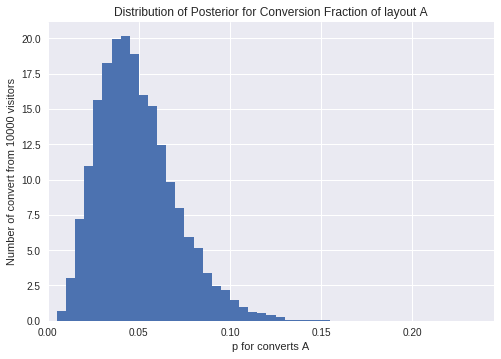

In [102]:
a_samples = take(10000, posterior_a_sampler)
ab_bins = [i/200.0 for i in range(50)]    # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=ab_bins, normed=True)   # normed=True gives a probability density function
plt.xlim(0, max(ab_bins))
plt.title("Distribution of Posterior for Conversion Fraction of layout A")
plt.xlabel('p for converts A')
plt.ylabel('Number of convert from 10000 visitors')
;

In [79]:
# Using Posterior distribution we can aswer the question "How likely it is that alyout A's conversion fraction is greater than 10%"
print("The likelyhood that layout A fraction exceedes 10% is {}%".format(100*sum(a > 0.1 for a in a_samples)/ len(a_samples)))
print("or")
print("we can be {}% certain layout A fraction is less than 10%".format(100-100*sum(a > 0.1 for a in a_samples)/ len(a_samples)))

The likelyhood that layout A fraction exceedes 10% is 2.27%
or
we can be 97.73% certain layout A fraction is less than 10%


<h4> Distribution of prior_sampler layout B</h4>

In [0]:
# sample from a normal distribution with known mean and standard distribution
def normal_prior_sampler(mu=0.06, sigma=0.02):
  """
  Args: mu and sigma of normal distribution
  Returns: yields stram of sample ffrom N(mu, sigma))
  """
  while True:
    x = random.normalvariate(mu=mu, sigma=sigma)
    if 0 <= x <= 1:
      yield x

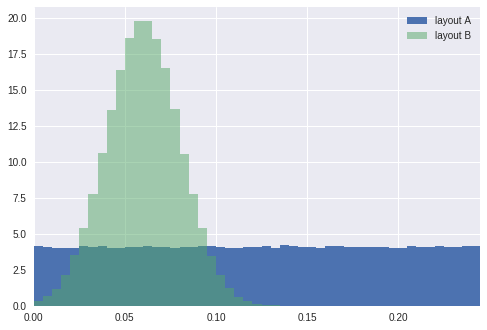

In [103]:
# compare uniform prior of layout and normal prior layout B
plt.hist(take(1000000, uniform_prior_sampler()),
        bins=ab_bins, label='layout A', normed=True)

plt.hist(take(1000000, normal_prior_sampler()),
        bins=ab_bins, label='layout B', alpha=0.5, normed=True)
plt.xlim(0, max(ab_bins))
plt.legend()

The guesses for layout B are concetrated around 6%, which is inline with our prior knowledge. 

Now that we have the prior sample for B, we can make its posterior sampler and take some samples

In [0]:
# posterior sampler for layour B
posterior_b_sampler = posterior_sampler(data=n_convert_b,
                                        prior_sampler=normal_prior_sampler(),
                                       simulate=lambda p: simulate_conversion(p, n_visitors_b))

b_samples = take(10000, posterior_b_sampler)

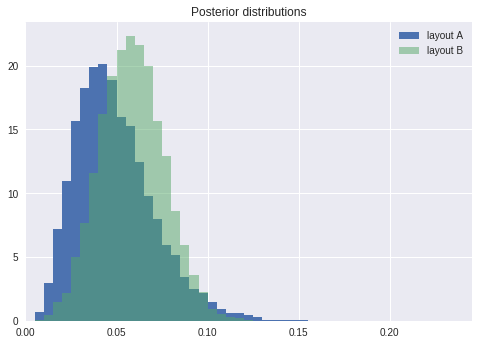

In [109]:
# visualize the two sets of posterior sample directly
plt.hist(a_samples, bins=ab_bins, label='layout A', normed=True)
plt.hist(b_samples, bins=ab_bins, label='layout B', normed=True, alpha=0.5)
plt.title('Posterior distributions')
plt.xlim(0, max(ab_bins));
plt.legend();

<h4> Conclusion: The posterior distribution plot shows that layout B is shifted to the right and this is telling us layout B is probably better than layout B</h4>

Answering the original question, i.e., how confident can we be that layout B is bettter?
- we can do pairwise comparisions between between the two list of estimated and measuring the fraction of pairs for which the estimated conversion of fraction of B is bigger that that for A

In [115]:
print("Given the data and our prior beliefs, er are {}% sure that layout B is better than A". \
      format(100*sum(b > a for a, b in zip(a_samples, b_samples))/len(a_samples)))

Given the data and our prior beliefs, er are 65.66% sure that layout B is better than A


To make business decision, we need to rub bigger A/B testing.

This tutorial is inspired by https://www.oreilly.com/learning/probabilistic-programming-from-scratch
